# 0. Эксперименты с bigCLAM, weightedBigCLAM и gammaModel

Основные цели: 

* Проверить как ведет себя логарифм правдоподобия трех моделей
* Проверить адекватность поведения моделей в зависимости от начальных приближений
* Убедиться в отсутствии ошибок в коде

Везде, где можно, будем смотреть на поведение моделей при разных значениях количества сообществ (истинное количество и одно дополнительное). Местами будут выводы.

Подбор Membership пока тупой и местами может работать хуже, чем мог бы

In [1]:
import numpy as np
import scipy as sp
import scipy.spatial as spatial
import matplotlib.pyplot as plt
import networkx as nx
import cPickle
from Extends import toBigClamFormat, fromBigClamFormat
import subprocess
import os
from big_clam import BigClam
from big_clam_gamma import BigClamGamma
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline 

In [ ]:
from IPython.parallel import Client
rc = Client()

In [ ]:
%px plot(rand(100))

In [2]:
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = size / 200     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

# 1. Тесты

Все что касается тестов, визуализации далее

In [3]:
test_size = 1
Fs2 = [2 * np.array([[1, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 1, 1, 1]]),
       2 * np.array([[1, 1, 1, 1, 1, 0, 0, 0], [0, 0, 0, 1, 1, 1, 1, 1]]),
       2 * np.array([[1, 1, 1, 1, 1, 1, 0, 0], [0, 0, 1, 1, 1, 1, 1, 1]]),
       2 * np.array([[1, 1, 1, 5, 5, 5, 0, 0], [0, 0, 5, 5, 5, 1, 1, 1]]),
       1 * np.array([[4, 4, 4, 4, 4, 1, 1, 1], [1, 1, 1, 4, 4, 4, 4, 4]]),
       1 * np.array([[3, 3, 3, 5, 5, 5, 1, 1], [1, 1, 5, 5, 5, 3, 3, 3]]),
       2 * np.array([[1] * 100 * test_size + [0] * 100 * test_size, [0] * 100 * test_size + [1] * 100 * test_size]),
       2 * np.array([[1] * 150 * test_size + [0] * 50 * test_size, [0] * 50 * test_size + [1] * 150 * test_size]),
       2 * np.array([[1] * 120 * test_size + [0] * 80 * test_size, [0] * 80 * test_size + [1] * 120 * test_size]), ]

Fs3 = [2 * np.array([[1] * 80 * test_size + [0] * 60 * test_size,
                     [0] * 20 * test_size + [1] * 20 * test_size + [0] * 20 * test_size + [1] * 20 * test_size + 
                     [0] * 20 * test_size + [1] * 20 * test_size + [1] * 20 * test_size,
                     
                     [0] * 40 * test_size + [1] * 40 * test_size + [1] * 20 * test_size + 
                     [1] * 20 * test_size + [0] * 20 * test_size]), ]

In [4]:
# generate agency matix from F matrix for gamma model
def gamma_model_test_data(F = None):
    np.random.seed(1122)
    if F is None:
        F = 2 * np.array([[1, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 1, 1, 1]])
    theta = F.T.dot(F)
    A = np.zeros(theta.shape)
    for i in xrange(theta.shape[0]):
        for j in xrange(theta.shape[1]):
            A[i][j] = np.random.gamma(1 + theta[i][j], 1)
    np.fill_diagonal(A, 0)
    return (A+A.T)/2.0

In [5]:
# generate agency matix from F matrix
def big_clam_model_test_data(F = None):
    np.random.seed(1122)
    if F is None:
        F = 2 * np.array([[1, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 1, 1, 1]])
    theta = F.T.dot(F)
    P = 1 - np.exp(-theta)
    A = np.random.rand(*P.shape)- 1e-2 < P
    np.fill_diagonal(A, 0)
    A = (A+A.T)/2.0
    res = 1.0 * (A != 0)
    return res

# 2. Вспомогательные функции для красивой отрисовки

In [6]:
def draw_matrix(photo_l, title="", hide_ticks=True):
    if photo_l.shape[0] / photo_l.shape[1] > 5 or photo_l.shape[0] / photo_l.shape[1] < 0.2:
        k = np.floor(np.max(photo_l.shape) / np.min(photo_l.shape) / 2) 
        if photo_l.shape[1] < photo_l.shape[0]:
            photo_l = np.reshape(np.tile(photo_l.copy(), (k, 1)).T, (photo_l.shape[1]*k, photo_l.shape[0])).T
        else:
            photo_l = np.reshape(np.tile(photo_l.copy(), (1, k)), (photo_l.shape[0] * k, photo_l.shape[1]))
    ax = plt.gca()
    im = plt.imshow(photo_l, interpolation='none')
    if hide_ticks:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.title(title, y=1.02, x = 0.6)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="7%", pad=0.07)
    plt.colorbar(im, cax=cax, ticks=np.linspace(np.min(photo_l), np.max(photo_l), 5))

In [7]:
def draw_res(B, F_true, F_model, F_model7=None):
    Xs, Ys = 2, 5
    f = plt.figure(figsize=(18,6))

    plt.subplot(Xs, Ys, 1)
    draw_matrix(B, 'Agency matix sample (B)')
    plt.subplot(Xs, Ys, 2)
    draw_matrix(F_model.dot(F_model.T), 'Reconstructed matix ({} comm)'.format(F_model.shape[1]))
    plt.subplot(Xs, Ys, 3)
    draw_matrix(np.abs(F_model.dot(F_model.T)-F_true.T.dot(F_true)), 'diff ({} comm)'.format(F_model.shape[1]))   

    plt.subplot(Xs, Ys, 6)
    draw_matrix(F_true, "true F value")
    plt.subplot(Xs, Ys, 7)
    draw_matrix(F_model.T, "Reconstructed F ({} comm)".format(F_model.shape[1]))
    C = F_model > np.mean(F_model) * 0.9
    plt.subplot(Xs, Ys, 8)
    draw_matrix(C.T, "Membership ({} comm)".format(F_model.shape[1]))
    
    if F_model7 is not None:
        plt.subplot(Xs, Ys, 4)
        draw_matrix(F_model7.dot(F_model7.T), 'Reconstructed matix ({} comm)'.format(F_model7.shape[1]))
        plt.subplot(Xs, Ys, 5)
        draw_matrix(np.abs(F_model7.dot(F_model7.T)-F_true.T.dot(F_true)), 'diff ({} comm)'.format(F_model7.shape[1]))
        plt.subplot(Xs, Ys, 9)
        draw_matrix(F_model7.T, "Reconstructed F ({} comm)".format(F_model7.shape[1]))
        C7 = F_model7 > np.mean(F_model7) * 0.5
        plt.subplot(Xs, Ys, 10)
        draw_matrix(C7.T, "Membership ({} comm)".format(F_model7.shape[1]))

    #plt.subplot(Xs, Ys, 9)
    #draw_matrix(np.abs(F_model.T - F_true), "diff (3 comm)")

In [8]:
def draw_test_sample(F, A, B=None, C=None, x=None):
    Ys = 5 if C is not None else 4 if B is not None else 3
    plt.figure(figsize=(3+Ys*3,6))
    plt.subplot(1, Ys, 1)
    draw_matrix(F, "True F value")
    plt.subplot(1, Ys, 2)
    draw_matrix(F.T.dot(F), "A generation model")
    plt.subplot(1, Ys, 3)
    draw_matrix(A, "Agency matix sample (A)")
    if B is not None:
        plt.subplot(1, 5, 4)
        draw_matrix(B, "Zeros if A < {:.2f} (B)".format(x))
    if C is not None:
        plt.subplot(1, 5, 5)
        draw_matrix(C, "A < {:.2f} (C matrix)".format(x))

# 3. Пример с 3 пересекающимися сообществами

Для генерации матрицы смежности используется модель *gamma_model_test_data* с зашитым гамма распределением.
Т.к. должно быть все равно какое распределение имеют веса внутри сообществ.

Основной тест приведен ниже. Если все будет плохо тест будет упрощаться.

3.87460363258 4.84325454073 True


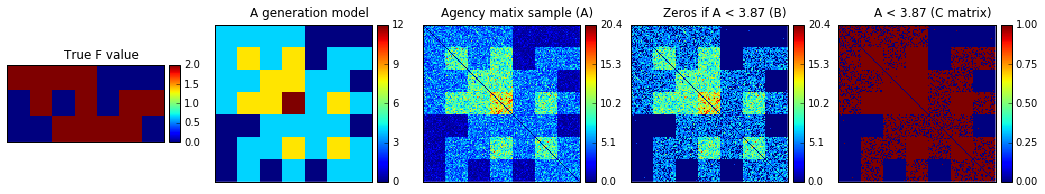

In [9]:
F_true = Fs3[0]
A = gamma_model_test_data(F_true)
#P = exp(-A / np.max(A))
#mask = P 
x = np.mean(A) * 0.8
print x, np.mean(A), np.all(A == A.T)
B = A.copy()
B[B < x] = 0
C = B.copy()
C[C >=x] = 1

draw_test_sample(F_true, A, B, C, x)

## 3.1 BigCLAM (взвешенный вариант)

Основная матрица смежности для работы — B

In [9]:
eps = 1e-4

w_model = BigClam(B, 3, debug_output=False, LLH_output=True, eps=eps)
F_model, LLH = w_model.fit()

w_model7 = BigClam(B, 7, debug_output=False, LLH_output=True, eps=eps)
F_model7, LLH7 = w_model7.fit()

iter: 140, LLH:-36981.7658482
iter: 280, LLH:-37118.4609407
iter: 420, LLH:-29798.5460427
iter: 560, LLH:-29515.5395773
iter: 700, LLH:-27506.409489
iter: 840, LLH:-27033.3567592
iter: 980, LLH:-26852.0806073
iter: 1120, LLH:-26883.8555777
iter: 1260, LLH:-26873.7847968
iter: 140, LLH:-27058.5397108
iter: 280, LLH:-31113.359168
iter: 420, LLH:-26780.4411113
iter: 560, LLH:-26679.9546659
iter: 700, LLH:-26446.9800753
iter: 840, LLH:-26548.1027535
iter: 980, LLH:-26486.1958676
iter: 1120, LLH:-26537.8497551


In [10]:
print "True LLH:  {:.2f}\n3 comm LLH:{:.2f}\n7 comm LLH:{:.2f}".format(w_model.loglikelihood(F_true.T), LLH, LLH7)

True LLH:  -18751.58
3 comm LLH:-26852.08
7 comm LLH:-26446.98


Наблюдаем, что у истинного F значение правдоподобия намного выше, что не удивительно, ведь модель генерации отличается от модели, которую использует BigClam.
Еще интересно, что при 3 и 7 сообществах значения правдоподобия очень похожи (см. подбор количества сообществ)

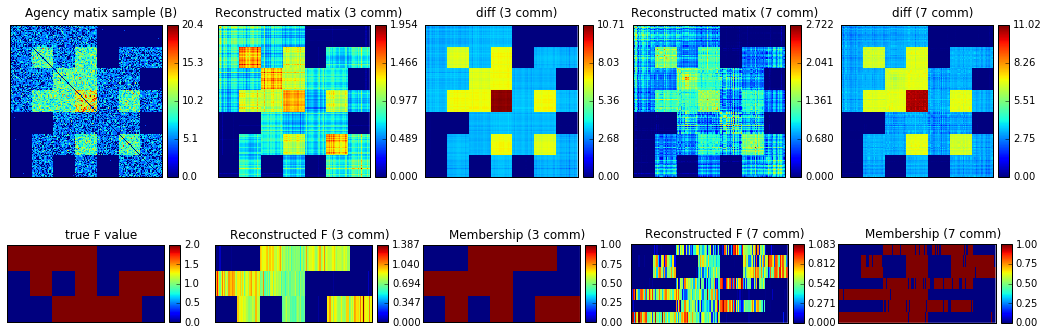

In [11]:
draw_res(B, F_true, F_model, F_model7)

** Интересное наблюдение: ** Если пытаемся восстановить больше сообществ, чем есть (6 график), то получаем сильно коррелированные сообщества. Возможно, так можно подбирать их количество.

## 3.2 BigCLAM (оригинальный вариант)

### Тестирование на не правильной гамма модели

Модель является не правильной, т.к. bigClAM оптимизирует не ее. Значит не стоит расчитывать на восстановление матрицы *F*. Однако, структура сообществ все равно может быть восстановлена, что и будет продемонстрированно.

Рассмотрим несколько вариантов инициализации.

#### Близкая к оптимуму инициализация

Используем только 3 сообщества, т.к. только для этого случая можем взять истинное значение и зашумить его:

In [12]:
noise_forse = 0.2
noise = -noise_forse + 2 * noise_forse * np.random.rand(*F_true.T.shape)
init =  1.0 * F_true.T + noise
init[init < 0] = 0

w_model2 = BigClam(C, 3, debug_output=False, LLH_output=False, initF=init, iter_output=1)
F_model2, LLH2 = w_model2.fit()


big_clam.py:297: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  F = self.initRandF() if self.initFmode == 'rand' else self.initNeighborComF() if self.initFmode is None else self.initFromSpecified()


3219


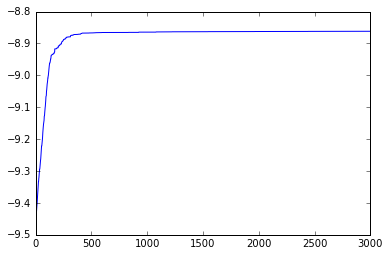

In [13]:
print len(w_model2.LLH_output_vals)
plt.plot(-np.log(-np.array(w_model2.LLH_output_vals[:3000])))

Типичная картина для правдоподобия.

In [14]:
print "True LLH:  {:.2f}, {:.2f}\n3 comm LLH:{:.2f}, {:.2f}".format(w_model2.loglikelihood(F_true.T), 
                                                                                           np.log(-w_model2.loglikelihood(F_true.T)), 
                                                                                           LLH2, np.log(-LLH2))

True LLH:  -11585.49, 9.36
3 comm LLH:-7055.11, 8.86


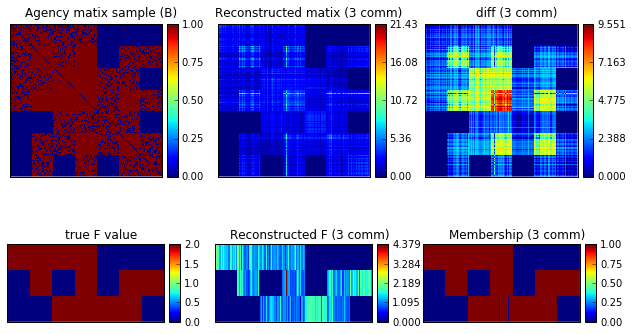

In [15]:
draw_res(C, F_true, F_model2)

#### Вывод

* Матрица А восстанавливается плохо, но это естественно, поскольку модель, которую оптимизирует BigCLAM, не совпадает с моделью генерации.
* Сама структура сообществ восстановлена достаточно хорошо.

#### Случайная инициализация

In [19]:
w_model2r = BigClam(C, 3, debug_output=False, LLH_output=False, initF='rand', iter_output=1)
F_model2r, LLH2r = w_model2r.fit()

w_model72r = BigClam(C, 7, debug_output=False, LLH_output=False, initF='rand', iter_output=1)
F_model72r, LLH72r = w_model72r.fit()

In [20]:
print "True LLH:  {:.2f}, {:.2f}\n3 comm LLH:{:.2f}, {:.2f}\n7 comm LLH:{:.2f}, {:.2f}".format(w_model2r.loglikelihood(F_true.T), 
                                                                                               np.log(-w_model2r.loglikelihood(F_true.T)), 
                                                                                               LLH2r, np.log(-LLH2r), LLH72r, np.log(-LLH72r))

True LLH:  -11585.49, 9.36
3 comm LLH:-7497.01, 8.92
7 comm LLH:-6307.96, 8.75


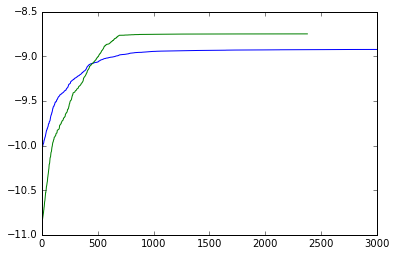

In [21]:
plt.plot(-np.log(-np.array(w_model2r.LLH_output_vals[:3000])), 'b-')
plt.plot(-np.log(-np.array(w_model72r.LLH_output_vals[:3000])), 'g-')

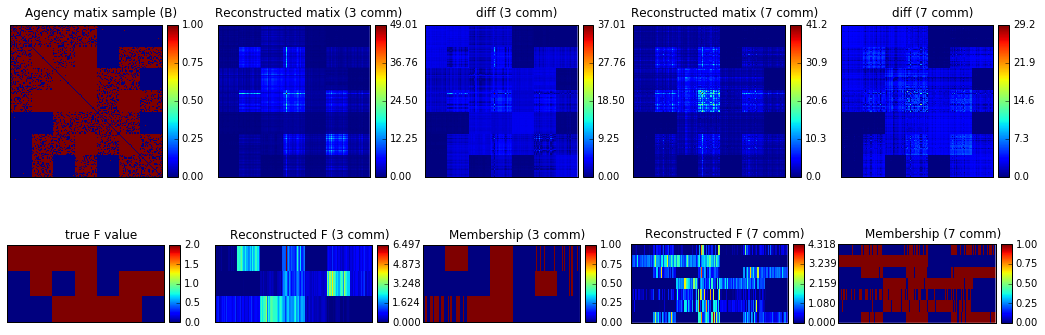

In [22]:
draw_res(C, F_true, F_model2r, F_model72r)

### Общий вывод
Оригинальный BigClam чувствителен к начальному приближению, а значит менее устойчив по сравнению с другими методами

### Правильная модель данных для BigCLAM

Рассмотрим более простой пример для оригинального алгоритма

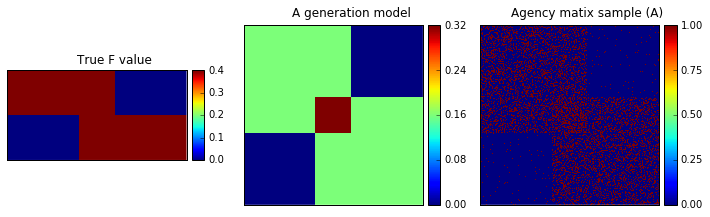

In [10]:
F_true_bc = 0.2 * Fs2[-1]
B_bc = big_clam_model_test_data(F_true_bc)
draw_test_sample(F_true_bc, B_bc)

### Случайная инициализация

In [91]:
w_model2_bc = BigClam(B_bc, 2, debug_output=False, LLH_output=False, initF='rand', iter_output=1)
F_model2_bc, LLH2_bc = w_model2_bc.fit()

w_model72_bc = BigClam(B_bc, 3, debug_output=False, LLH_output=False, initF='rand', iter_output=1)
F_model72_bc, LLH72_bc = w_model72_bc.fit()

2599


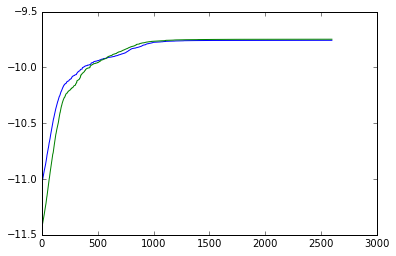

In [92]:
print len(w_model2_bc.LLH_output_vals)
plt.plot(-np.log(-np.array(w_model2_bc.LLH_output_vals[:3000])))
plt.plot(-np.log(-np.array(w_model72_bc.LLH_output_vals[:3000])))

Наблюдаем более адекватное поведедение правдоподобия

In [93]:
print "True LLH:  {:.2f}, {:.2f}\n3 comm LLH:{:.2f}, {:.2f}\n7 comm LLH:{:.2f}, {:.2f}".format(w_model2_bc.loglikelihood(F_true_bc.T), 
                                                                                               np.log(-w_model2_bc.loglikelihood(F_true_bc.T)), 
                                                                                               LLH2_bc, np.log(-LLH2_bc), LLH72_bc, np.log(-LLH72_bc))

True LLH:  -21424.18, 9.97
3 comm LLH:-17279.61, 9.76
7 comm LLH:-17111.51, 9.75


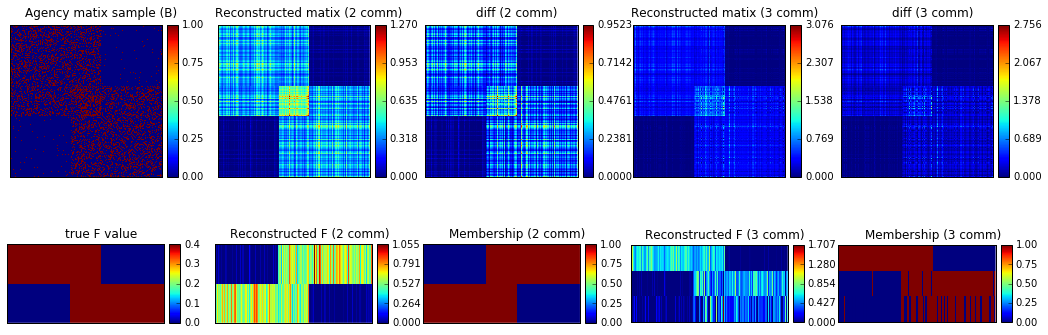

In [94]:
draw_res(B_bc, F_true_bc, F_model2_bc, F_model72_bc)

### Странное начальное приближение — странный результат

iter: 140, LLH:-36133.4253908
iter: 280, LLH:-15560.783104
iter: 420, LLH:-11497.0283767
iter: 560, LLH:-10003.1337119
iter: 700, LLH:-10200.6374988
iter: 840, LLH:-11306.9436593
iter: 980, LLH:-12749.7123458
Warning! Big LLH decrease!


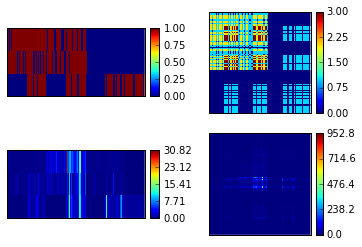

In [28]:
w_model2t = BigClam(C, 3, debug_output=False, LLH_output=True)
F_model2t, LLH2t = w_model2t.fit()
plt.figure()
plt.subplot(221)
draw_matrix(w_model2t.initFmode.T)
plt.subplot(222)
draw_matrix(w_model2t.initFmode.dot(w_model2t.initFmode.T))
plt.subplot(223)
draw_matrix(F_model2t.T)
plt.subplot(224)
draw_matrix(F_model2t.dot(F_model2t.T))

Такое приближение выдал мой алгоритм на этом примере. Из него тоже ничего не сходится.

**TODO:** Посмотреть, что за приближение такое странное, так ли происходит в оригрнале.

## 3.3 Гамма модель

### Случайная инициализация

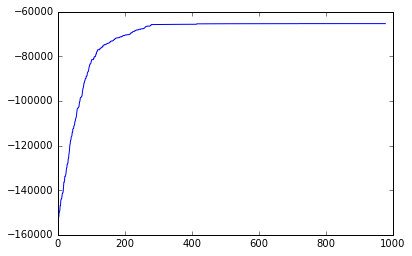

In [29]:
    w_model3r = BigClamGamma(B, 3, debug_output=False, LLH_output=False, initF='rand', iter_output=1)
    F_model3r, LLH3r = w_model3r.fit()
    
    plt.plot(w_model3r.LLH_output_vals)
    w_model73r = BigClamGamma(B, 7, debug_output=False, LLH_output=False, initF='rand', iter_output=1)
    F_model73r, LLH73r = w_model73r.fit()

# print len(w_model3r.LLH_output_vals)
plt.plot(-np.log(-np.array(w_model3r.LLH_output_vals[:3000])))

print len(w_model73r.LLH_output_vals)
plt.plot(-np.log(-np.array(w_model73r.LLH_output_vals[:3000])))

In [31]:
print "True LLH:  {:.2f}\n3 comm LLH:{:.2f}\n7 comm LLH:{:.2f}".format(w_model3r.loglikelihood(F_true.T), LLH3r, LLH73r)

True LLH:  -91291.62
3 comm LLH:-65381.10
7 comm LLH:-67338.49


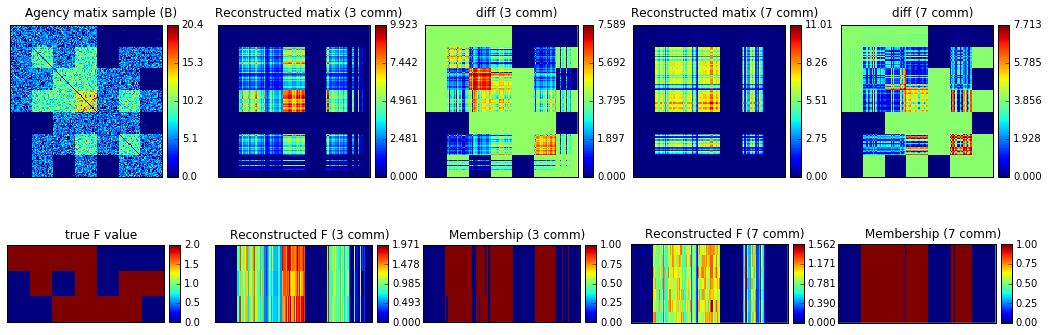

In [32]:
draw_res(B, F_true, F_model3r, F_model73r)

**Вывод:** Для случайного начального приближения ничего не работает.

### Инициализация правильным значением

In [33]:
    w_model3 = BigClamGamma(A, 3, debug_output=False, LLH_output=False, initF=1.0 * F_true.T, iter_output=1)
    F_model3, LLH3 = w_model3.fit()

# print len(w_model3.LLH_output_vals)
plt.plot(-np.log(-np.array(w_model3.LLH_output_vals[:3000])))

print len(w_model3.hist[3])

Все шаги были нулевыми

In [35]:
print "True LLH:  {:.2f}\n3 comm LLH:{:.2f}".format(w_model3.loglikelihood(F_true.T), LLH3)

True LLH:  -40118.76
3 comm LLH:-40118.76


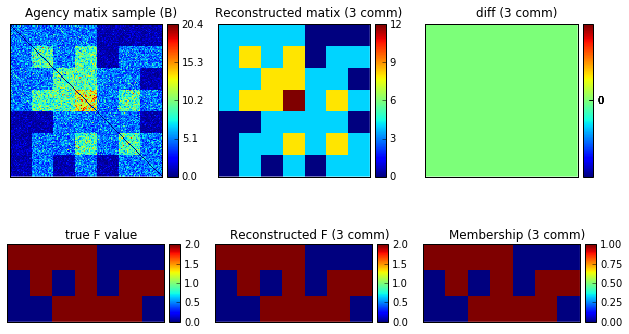

In [36]:
draw_res(A, F_true, F_model3)

**Вывод:** Оптимизационная схема работает правильно

### Инициализация правильным значением с отклонением

In [37]:
    noise_forse = 0.2
    noise = -noise_forse + 2 * noise_forse * np.random.rand(*F_true.T.shape)
    init =  1.0 * F_true.T + noise
    init[init<0.01] = 0.01
    w_model3 = BigClamGamma(A, 3, debug_output=False, LLH_output=False, initF=init, iter_output=1)
    F_model3, LLH3 = w_model3.fit()

279
4


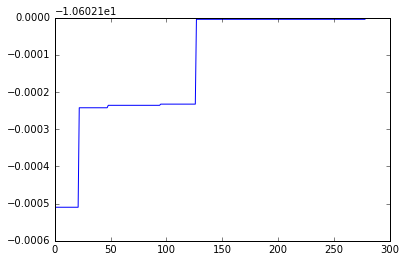

In [38]:
print len(w_model3.LLH_output_vals)
plt.plot(-np.log(-np.array(w_model3.LLH_output_vals[:3000])))

print len(w_model3.hist[3])

In [39]:
print "True LLH:  {:.2f}\n3 comm LLH:{:.2f}".format(w_model3.loglikelihood(F_true.T), LLH3)

True LLH:  -40118.76
3 comm LLH:-40219.39


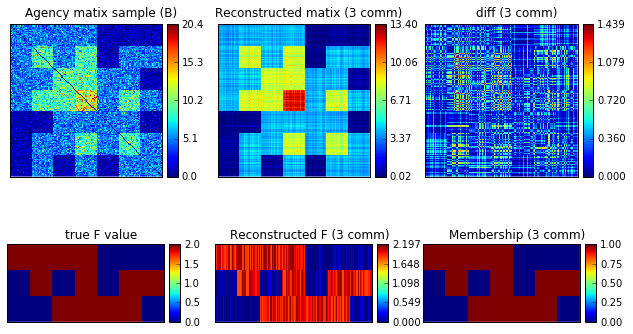

In [40]:
draw_res(A, F_true, F_model3)

### Общий вывод

* Отличное восстановление из хорошего приближения
* Необходимо придумать хорошее приближение

# 4. Подбор количества сообществ

Было замечено, что при увеличении числа сообществ, логарифм правдоподобия не сильно возрастает после того, как пройдено истинное число сообществ. Проверим этот факт.

In [13]:
eps = 1e-2
comm_count = range(1, 10)
Fs, LLHs = zip(*[BigClam(B, i, debug_output=False, LLH_output=False, eps=eps).fit() for i in comm_count])

Warning! Big LLH decrease!
Warning! Big LLH decrease!
Warning! Big LLH decrease!


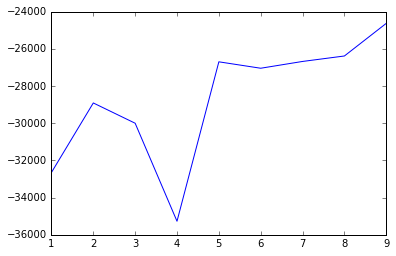

In [17]:
#print '\n'.join("LLH{0}:".format(x)+" {:.2f}" for x in comm_count).format(*LLHs)
plt.plot(comm_count, LLHs)


На модельных данных факт не сильно заметен, хотя прослеживается. Максимум достигается на двух сообществах, хотя на самом деле их 3.

### Проверка на реальных данных

In [19]:
s = 0
import os
DATA_PATH = '../data/vk/'
ego_paths = [f for f in os.listdir(DATA_PATH) if f.endswith(".ego")]
Fss = []
LLHs = []
comm = range(1, 15)
for ego in ego_paths:
    D = cPickle.load(file('../data/vk/{}'.format(ego)))
    G = nx.Graph(D)
    A = np.array(nx.to_numpy_matrix(G))
    Fs = []
    LLH = []
    for k in comm:
        bigClam = BigClam(A, k, sparsity_coef=s, LLH_output=False, eps = 1e-2)
        res = bigClam.fit(A, k)
        Fs.append(res[0])
        LLH.append(res[1])
        print ".",
    Fss.append(Fs)
    LLHs.append(LLH)
    print "."

. . . . . . . . . . . . . . .
. . . . . . . . . . . . . . .
. . . . . . . . . . . . . . .
. . . . . . . . . . . . . . .


Ниже продемонстрирован просто способ подбора количества сообществ. Если прирост опускается ниже чем 0.05 от первоначального, то считается, что оптимум по количесву сообществ достигнут. Приведен пример для 4 реальных графов. 

** TODO: ** Проверить как будет работать блочная L1 регуляризация.

4 2 4 3


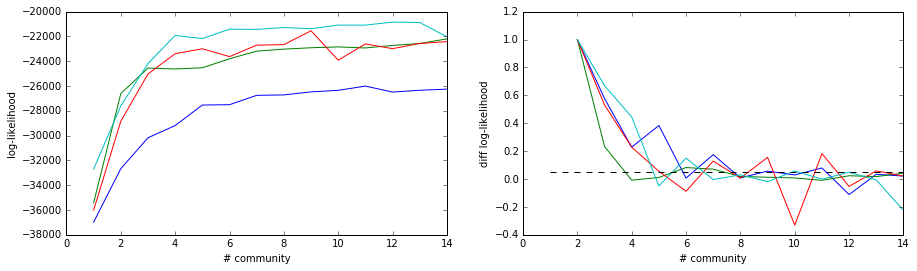

In [39]:
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(comm, np.array(LLHs).T)
plt.xlabel("# community")
plt.ylabel("log-likelihood")
plt.subplot(122)

dLLHs = np.diff(np.array(LLHs)).T
dLLHs = dLLHs / dLLHs[0,:]
for dLLH in dLLHs.T:
    plt.plot(comm[1:], dLLH)  
plt.xlabel("# community")
plt.ylabel("diff log-likelihood")
bord = 0.05
plt.plot([min(comm), max(comm)],[bord, bord], 'k--')
for dLLH in dLLHs.T:
    print np.nonzero(dLLH < bord)[0][0],
  

Так же вопрос можно изучить со стороны степени коррелированности матрицы F, что было замечено на многочисленных примерах.

In [146]:
def calc_corr(F):
    #print 
    X = np.sum(F, axis=1)
    Fn = F[X!=0,:] * (1 / X[X!=0,None])
    pen = Fn.T.dot(Fn)
    #print pen.shape
    np.fill_diagonal(pen, 0)
    pen = np.sum(pen) / F.shape[1]
    return pen

def calc_dist(F):
    X = spatial.distance.pdist(F.T, metric='cosine')
    return sum(X) / X.shape[0] if X.shape[0] != 0 else 0

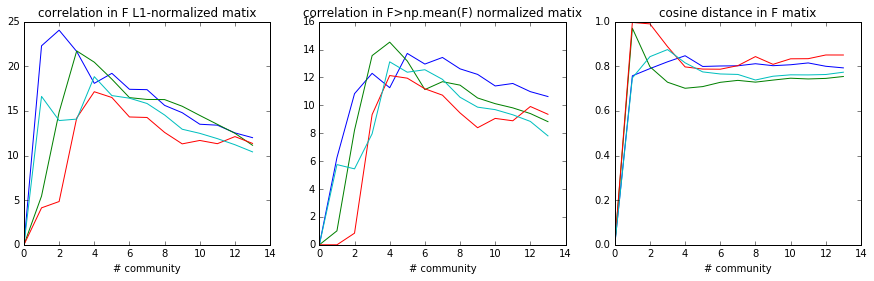

In [151]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.plot(np.array([[calc_corr(F) for F in Fs] for Fs in Fss]).T)
plt.xlabel("# community")
plt.title("correlation in F L1-normalized matix")
plt.subplot(132)
plt.plot(np.array([[calc_corr(1.0*(F>np.mean(F))) for F in Fs] for Fs in Fss]).T)
plt.xlabel("# community")
plt.title("correlation in F>np.mean(F) normalized matix")
plt.subplot(133)
plt.plot(np.array([[calc_dist(F) for F in Fs] for Fs in Fss]).T)
plt.xlabel("# community")
plt.title("cosine distance in F matix")

### Выводы
* Метод сломанной трости применим к задаче.
* Интересное поведение у степени коррелированности матрицы F -- с ростом количества сообществ оно падает, что противоречит предположению. (Выводы?)

**TODO:** Проверить на каких-нибудь бенчмарках.

# 5. Зависимость качества оптимизации от размера сообщества

**Задача:** Потестировать качество работы алгоритма в зависимости от размеров модельного графа (кол-ва вершин в каждом сообществе)

In [10]:
def simple_test(size=20, overlapping=10):
    return np.array([[1.0] * size + [0.0] * (size - overlapping), [0.0] * (size-overlapping) + [1.0] * size])

In [29]:
s = 0
LLHs = []
Fss = []
LLHs_true = []
sizes = [5,6,7,8,9, 10,12,14,16,18, 20,30, 40,50,60,70, 100, 150]
overlappings = [0, 0.05, 0.1, 0.2, 0.5, 0.75]
for size in sizes:
    LLH = []
    LLH_true = []
    Fs = []
    for overlapping in overlappings:
        F = 0.5 * simple_test(size, np.floor(overlapping*size))
        A = big_clam_model_test_data(F)
        #draw_test_sample(F, A)
        bigClam = BigClam(A, 2, sparsity_coef=s, LLH_output=False)
        res = bigClam.fit()
        Fs.append(res[0])
        LLH.append(res[1])
        LLH_true.append(bigClam.loglikelihood(F.T))
        print ".",
    Fss.append(Fs)
    LLHs.append(LLH)
    LLHs_true.append(LLH_true)
    print "."

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .


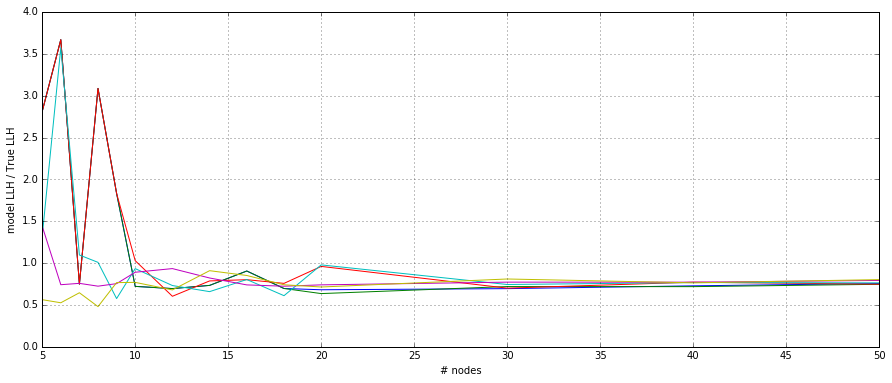

In [40]:
plt.figure(figsize=(15,6))
plt.plot(sizes, np.array(LLHs) / np.array(LLHs_true), label=["0", "0.05", "0.1", "0.2", "0.5", "0.75"])
plt.xlim([5,50])
plt.grid()
plt.xlabel("# nodes")
plt.ylabel("model LLH / True LLH")

Видно, что до некоророго момента (<10 вершин) модель переобучается.
После 10 выходит на некоторый постоянный уровень провдоподобия (75-80% от истинного)

# 6. Регуляризация для декорреляции матрицы F

**Проблема:** Часто метод выдает сообщества, которые имеют значительные пересечения между собой. Хочется избавится от этой особенности. Для избавления будем добавлять следующий регуляризатор:

$$
Pen = -\alpha \sum_{i\ne j}F_i^T F_j.
$$

Протестируем поведение коррелированности в зависимости от коэффициента $ \alpha $. Построим график зависимости $ Pen/\alpha $ от $\alpha$.
Проведем эксперимент на реальных данных для трех случаев: малого числа сообществ (2), оптимального (4), и большого (8)

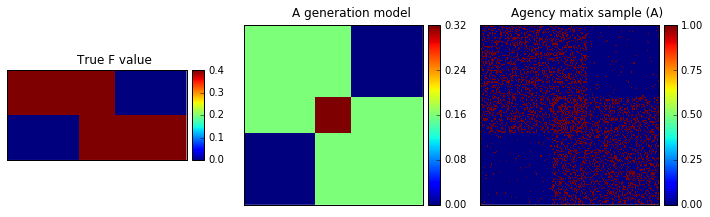

In [70]:
test_size = 8
F_true_bc = 0.4 * np.array([[1] * 12 * test_size + [0] * 8 * test_size, [0] * 8 * test_size + [1] * 12 * test_size])
B_bc = big_clam_model_test_data(F_true_bc)
draw_test_sample(F_true_bc, B_bc)

In [85]:
K = 3
sparsity_coefs = np.linspace(1, 500, 100)
init = None

Fs = []
pen = []
for s in log_progress(sparsity_coefs):
    bigClam = BigClam(B_bc, K, sparsity_coef=s, initF='rand' if init is None else init, debug_output=False, LLH_output=False, eps=1e-4, alpha=0.1)
    Fs.append(bigClam.fit())
    pen.append(bigClam.calc_penalty(Fs[-1][0], real=True))
    if init is None:
        init = bigClam.initFmode.copy()

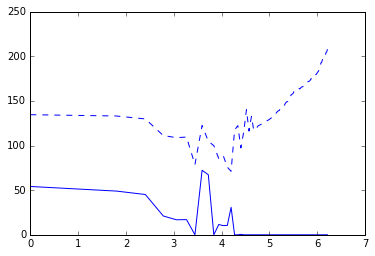

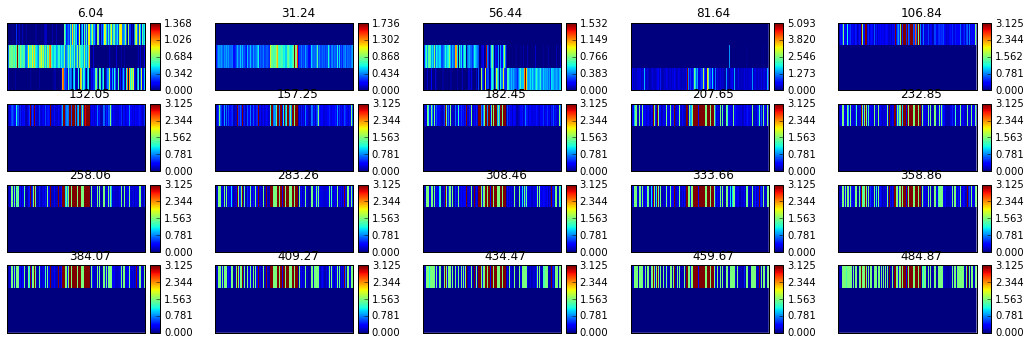

In [86]:
plt.plot(np.log(0.000001 + np.array(sparsity_coefs)), np.array(pen), 'b')
plt.plot(np.log(0.000001 + np.array(sparsity_coefs)), np.array([np.sum(np.abs(F[0])) for F in Fs]), 'b--')
plt.figure(figsize=(18, 7))
for j in xrange(1, 100, 5):
    plt.subplot(5, 5, np.floor(j / 5) + j % 5)
    draw_matrix(Fs[j][0].T, np.floor(100* sparsity_coefs[j]) / 100)

Первое, что бросается в глаза -- неустойчивое поведение правдоподобия. Там, где значение достигает нуля, обычно матрица F просто нулевая (локальный минимум). Возможно, это можно поправить, если отделяться от нуля небольшим значением. Без этого видим, что оптимизационная процедура сваливаеся в 0.

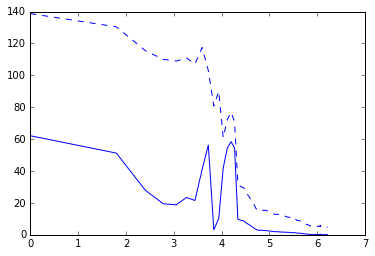

In [87]:
K = 3
sparsity_coefs = np.linspace(1, 500, 100)
init = None

Fs = []
pen = []
for s in log_progress(sparsity_coefs):
    bigClam = BigClam(B_bc, K, sparsity_coef=s, initF='rand' if init is None else init, debug_output=False, LLH_output=False, eps=1e-4, alpha=0.1, zero_eps=0.01)
    Fs.append(bigClam.fit())
    pen.append(bigClam.calc_penalty(Fs[-1][0], real=True))
    if init is None:
        init = bigClam.initFmode.copy()

plt.plot(np.log(0.000001 + np.array(sparsity_coefs)), np.array(pen), 'b')
plt.plot(np.log(0.000001 + np.array(sparsity_coefs)), np.array([np.sum(np.abs(F[0])) for F in Fs]), 'b--')

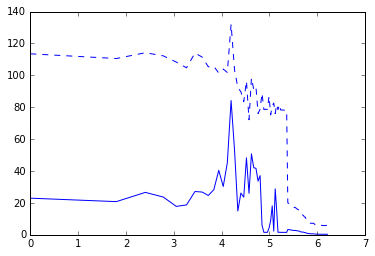

In [88]:
K = 2
sparsity_coefs = np.linspace(1, 500, 100)
init = None

Fs = []
pen = []
for s in log_progress(sparsity_coefs):
    bigClam = BigClam(B_bc, K, sparsity_coef=s, initF='rand' if init is None else init, debug_output=False, LLH_output=False, eps=1e-4, alpha=0.1, zero_eps=0.01)
    Fs.append(bigClam.fit())
    pen.append(bigClam.calc_penalty(Fs[-1][0], real=True))
    if init is None:
        init = bigClam.initFmode.copy()

plt.plot(np.log(0.000001 + np.array(sparsity_coefs)), np.array(pen), 'b')
plt.plot(np.log(0.000001 + np.array(sparsity_coefs)), np.array([np.sum(np.abs(F[0])) for F in Fs]), 'b--')

In [89]:
    K = 4
    import os
    DATA_PATH = '../data/vk/'
    ego_paths = [f for f in os.listdir(DATA_PATH) if f.endswith(".ego")]
    Fss = []
    pens = []
    #sparsity_coefs = [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]
    sparsity_coefs = [0.001, 0.01, 0.1, 1, 10, 100, 200]
    for ego in ego_paths:
        D = cPickle.load(file('../data/vk/{}'.format(ego)))
        G = nx.Graph(D)
        A = np.array(nx.to_numpy_matrix(G))
        Fs = []
        pen = []
        init = None
        for s in log_progress(sparsity_coefs):
            bigClam = BigClam(A, K, sparsity_coef=s, initF='rand', debug_output=False, LLH_output=False)
            Fs.append(bigClam.fit())
            pen.append(bigClam.calc_penalty(Fs[-1][0], real=True))
            if init is None:
                init = bigClam.initFmode.copy()
        Fss.append(Fs)
        pens.append(pen)

Рассмотрим аналогичный пример на реальных данных, посмотрим на матрицу F в зависимости от коэффициента:

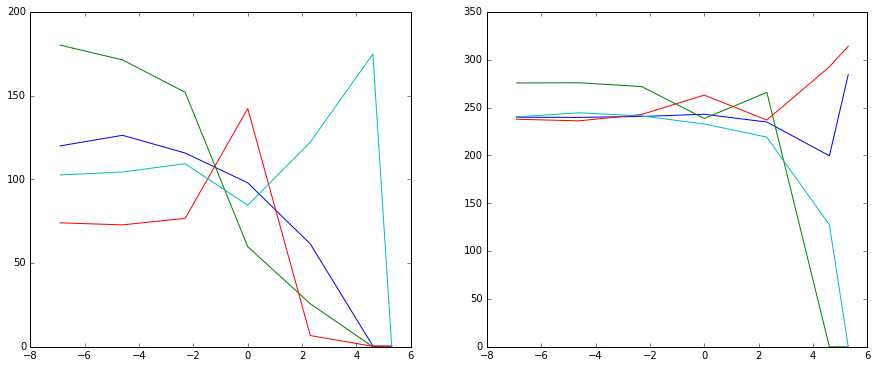

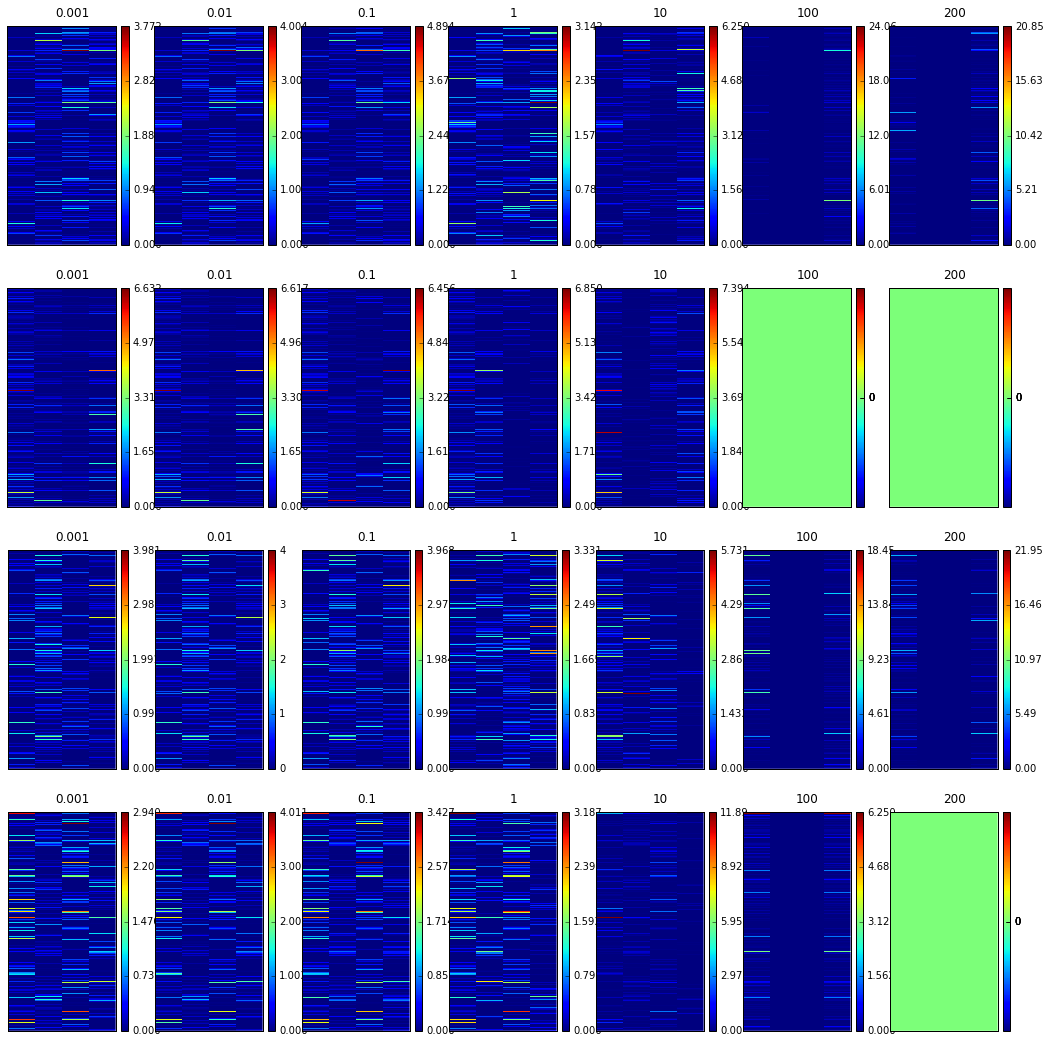

In [95]:
plt.figure(figsize=(15,6))
plt.subplot(121)
for pen in pens:
    plt.plot(np.log(0.000001 + np.array(sparsity_coefs)), np.array(pen))
plt.subplot(122)
for Fs in Fss:
    plt.plot(np.log(0.000001 + np.array(sparsity_coefs)), np.array([np.sum(np.abs(F[0])) for F in Fs]))

plt.figure(figsize=(18,18))
for i, Fs in enumerate(Fss):
    for j, F in enumerate(Fs):
        plt.subplot(len(ego_paths), len(sparsity_coefs), j+i*len(Fs)+1)
        draw_matrix(F[0], sparsity_coefs[j])

Видна похожая тенденция при больших значениях штрафа -- в матрице F зануляется часть сообществ, возможно, это можно использовать для поддобра количества сообществ в графе, не ясно как подбирать величину штрафа.

Отделим значение F от нуля значением 0.01 и проведем такой же эксперимент для модельных данных

# 7. Зависимость качества оптимизации от параметра alpha

Параметр из процедуры подбора шага *backtrakingLineSearch*.

Будем проверять на самом простом примере с 2 сообществами и на реальных данных

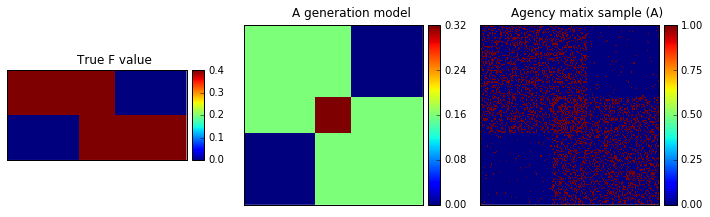

In [18]:
test_size = 8
F_true_bc = 0.4 * np.array([[1] * 12 * test_size + [0] * 8 * test_size, [0] * 8 * test_size + [1] * 12 * test_size])
B_bc = big_clam_model_test_data(F_true_bc)
draw_test_sample(F_true_bc, B_bc)

In [45]:
K = 2
init = None

Fs = []
itersLLH = []
alphas = [0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
for alpha in log_progress(alphas):
    bigClam = BigClam(B_bc, K, initF='rand' if init is None else init, debug_output=False, LLH_output=False, eps=1e-2, alpha=alpha, iter_output=1)
    res = bigClam.fit()
    Fs.append(res[0])
    itersLLH.append(bigClam.LLH_output_vals)
    if init is None:
        init = bigClam.initFmode.copy()

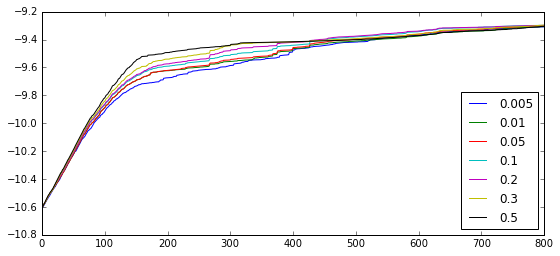

In [47]:
plt.figure(figsize=(9,4))
for llh, alpha in zip(itersLLH, alphas):
    plt.plot(-np.log(-np.array(llh[:800])), label=str(alpha))
plt.legend(loc=4)

На маленьком тестовом примере значение alpha почти ни на что не влияет.

Посмотрим на реальных данных.

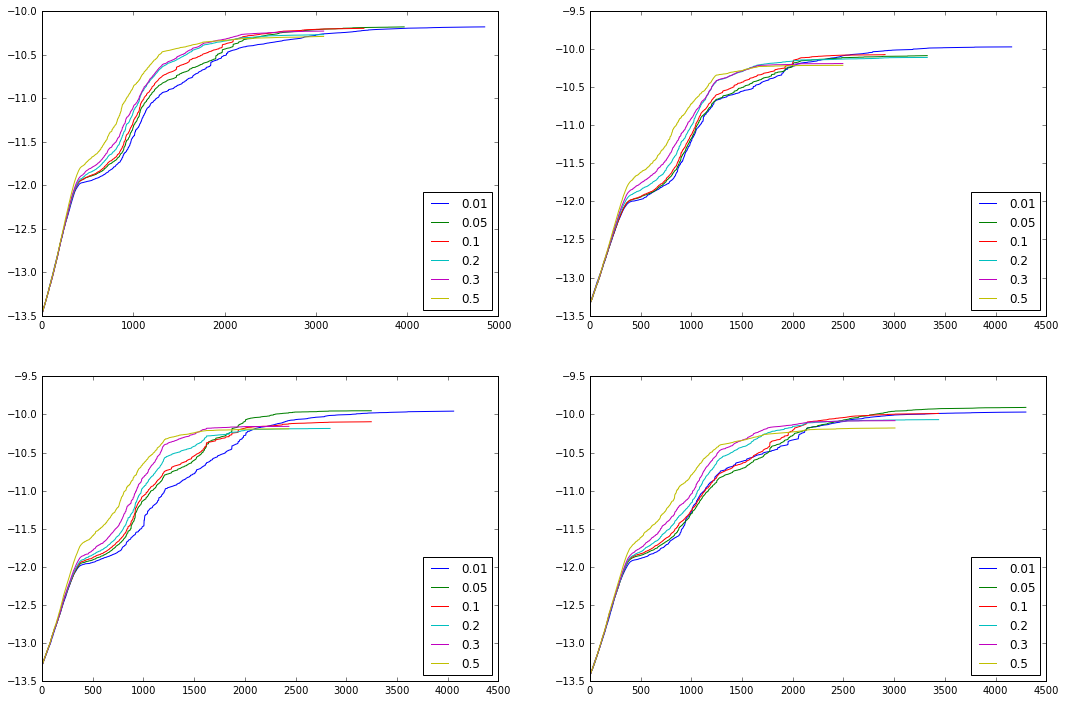

In [96]:
K = 4
import os
DATA_PATH = '../data/vk/'
ego_paths = [f for f in os.listdir(DATA_PATH) if f.endswith(".ego")]

alphas = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
plt.figure(figsize=(18,12))
for indx, ego in enumerate(ego_paths):
    D = cPickle.load(file('../data/vk/{}'.format(ego)))
    G = nx.Graph(D)
    A = np.array(nx.to_numpy_matrix(G))
    init = None
    Fs = []
    itersLLH = []
    for alpha in log_progress(alphas):
        bigClam = BigClam(A, K, initF='rand' if init is None else init, debug_output=False, LLH_output=False, eps=1e-2, alpha=alpha, iter_output=1)
        res = bigClam.fit()
        Fs.append(res[0])
        itersLLH.append(bigClam.LLH_output_vals)
        if init is None:
            init = bigClam.initFmode.copy()
    plt.subplot(2,2,indx+1)
    for llh, alpha in zip(itersLLH, alphas):
        plt.plot(-np.log(-np.array(llh)), label=str(alpha))
    plt.legend(loc=4)